In [321]:
#[0]
import numpy as np
from gensim.models.keyedvectors import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.test.utils import datapath, get_tmpfile
import json #https://stackoverflow.com/questions/7100125/storing-python-dictionaries
import pickle #https://stackoverflow.com/questions/11218477/how-can-i-use-pickle-to-save-a-dict
import os
#[1]
from sklearn.manifold import MDS
from scipy.spatial import procrustes
import matplotlib.pyplot as plt

%matplotlib inline

#[2]
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

#[3]
from sklearn import decomposition
from scipy.spatial import distance_matrix

In [324]:
embs = get_final_embs()

In [326]:
sentiments = get_sentiments()

# Calculando os valores críticos em cada embeddings

In [327]:
counter = 0
for j in embs:
    real = j.copy()
    distances_real = distance_matrix(real,real)
    iterations = 300
    trocas = 10
    erros = []
    for i in range(iterations):
        mod = real.copy()
        for j in range(trocas):
            a,b = np.random.randint(len(sentiments),size=2)
            while(a==b):
                a,b = np.random.randint(len(sentiments),size=2)
            mod[a] = real[b]
            mod[b] = real[a]

        distance_mod = distance_matrix(mod,mod)
        erro = calcula_stress(distances_real,distance_mod)
        erros += [erro]
    print(counter, np.mean(erros),np.var(erros),sorted(erros)[15])
    counter += 1

0 0.01963770303444889 1.2410491046435023e-05 0.014035716456828372
1 0.018551266093093214 8.449276495975577e-06 0.01401244401621582
2 0.024069114910266882 1.5283673120202507e-05 0.01787417956152285
3 0.02212652558120395 1.0843939191918021e-05 0.01675619423386639
4 0.02165609768315085 8.91291316198842e-06 0.016796828904386298
5 0.02015185794431334 7.848230030834878e-06 0.01581125231344866


# Distancia calculada Nas dimensoes originais do problema

In [328]:
dists = []
embs = get_final_embs()
for e in embs:
    dists += [distance_matrix(e,e)]
errors = np.zeros((len(dists),len(dists)))
for i in range(len(dists)):
    for j in range(len(dists)):
        errors[i][j] = np.round(calcula_stress(dists[i],dists[j]),4)
errors

array([[0.    , 0.0219, 0.0293, 0.0276, 0.0162, 0.0224],
       [0.0205, 0.    , 0.0202, 0.0205, 0.0169, 0.0125],
       [0.0275, 0.0202, 0.    , 0.0178, 0.0173, 0.0139],
       [0.0259, 0.0205, 0.0178, 0.    , 0.0176, 0.0137],
       [0.0159, 0.0177, 0.0181, 0.0184, 0.    , 0.0136],
       [0.021 , 0.0125, 0.0139, 0.0137, 0.013 , 0.    ]])

In [312]:
for i,n in enumerate(errors):
    print(i,np.sum(n))

0 0.097
1 0.09820000000000001
2 0.0955
3 0.1117
4 0.07270000000000001
5 0.0717


In [269]:
stress = []
x = []
for i in range(1,12):
    x+=[i]
    r =MDS(n_components=i,max_iter=3000,n_init=10).fit(embs[0])
    stress += [r.stress_]
    print(i,r.stress_,calcula_stress_embeddings(embs[0],r.embedding_)*20/0.13)

1 20.007582089906613 20.982829051880394
2 9.773765528439679 14.661316210765118
3 6.165058672817267 11.639980189073045
4 4.347621544527844 9.77329093500574
5 3.292842817669035 8.50379138212798
6 2.69144037691381 7.686677825347472
7 2.240189156468057 7.010216010528246
8 1.930922736434995 6.507107871289905
9 1.6536775985185939 6.020166221364168
10 1.4731764846488415 5.68023119459122
11 1.3160330740923003 5.366919226599249


([<matplotlib.axis.XTick at 0x7f463e43d6d0>,
 <a list of 11 Text xticklabel objects>)

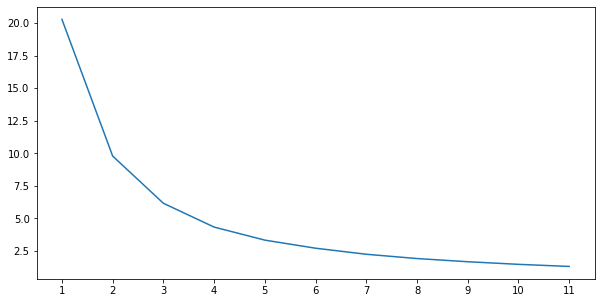

In [251]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(x,stress)
plt.xticks(np.arange(min(x), max(x)+1, 1.0))

In [ ]:
ax.

In [323]:
def get_emotion_embedding():
    return get_emb_concat()

def get_final_embs(dimensions = 200):
    embs = get_clean_embeddings()
    embs += [get_emb_soma()]
    embs += [get_emb_concat()]


    mds = MDS(n_components=dimensions)
    #Trata embeddings, filtrando somente os sentimentos principais e colocando no numero minimo de dimensoes
    embeddings = []
    for i in range(len(embs)):
        transformed_embedding = mds.fit_transform(embs[i])
        embeddings += [transformed_embedding]
    embs = embeddings

    for a in range(len(embs)):
        for b in range(len(embs)):
            embs[a],embs[b],r = procrustes(embs[a],embs[b])
    for i in range(200):
        a = np.random.randint(len(embs))
        b = np.random.randint(len(embs))
        embs[a],embs[b],r = procrustes(embs[a],embs[b])
    return embs

def calcula_stress_embeddings(d_original, d_proposta):
    d_original = distance_matrix(d_original,d_original)
    d_proposta = distance_matrix(d_proposta,d_proposta)
    a = np.sum((d_original-d_proposta)**2)
    b = np.sum(d_original**2)
    return np.sqrt(a/b)/4

def calcula_stress(d_original, d_proposta):
    a = np.sum((d_original-d_proposta)**2)
    b = np.sum(d_original**2)
    return np.sqrt(a/b)/4

def get_emb_soma():
    embeddings = get_clean_embeddings()
    sentiments = get_sentiments()
    assemble_embeddings_soma = np.zeros_like(embeddings[0])
    for i in embeddings:
        for c in range(len(sentiments)):
            assemble_embeddings_soma[c] = assemble_embeddings_soma[c] + i[c]
    return assemble_embeddings_soma

def get_emb_concat():
    embeddings = get_clean_embeddings()
    sentiments = get_sentiments()
    assemble_embeddings_concat = []

    for c in range(len(sentiments)):
        tmp = np.array([])
        for i in embeddings:
            tmp = np.concatenate((tmp,i[c]))
        assemble_embeddings_concat += [tmp]
    return assemble_embeddings_concat


def get_emb_media():
    #média dos vetores e retirando outliers
    embeddings = get_clean_embeddings()
    sentiments = get_sentiments()
    assemble_embeddings_media = np.zeros_like(embeddings[0])
    vec = []
    dist = []
    for c in range(len(sentiments)):
        tmp = np.array([])
        vec = []
        for i in embeddings:
            vec += [i[c]]

        centroid = np.zeros_like(vec[0])
        for i in vec:
            centroid = centroid + i
        centroid = centroid/len(vec)

        dist = []
        for i in vec:
            dist += [np.linalg.norm(i-centroid)]

        limitante_distancia_para_corte = np.max(dist)

        counter = 0
        for n,i in enumerate(embeddings):
            if dist[n]!=limitante_distancia_para_corte:
                assemble_embeddings_media[c] += i[c] 
                counter+=1

        assemble_embeddings_media[c] = assemble_embeddings_media[c]/counter
    return assemble_embeddings_media


def get_clean_embeddings():
#Seleciona somente os vetores principais das nossas embeddings
    sentiments = get_sentiments()
    raw_embeddings = []
    dimensions_size = []
    for i in range(4):
        tmp = get_vectors_embedding(i)
        raw_embeddings += [tmp]
        dimensions_size+=[len(get_sentiment_vector(tmp,sentiments[0]))]
#Faz o corte para o menor tamanho de dimensão
    n_dimensions = np.min(dimensions_size)
    # n_dimensions = 10
    mds = MDS(n_components=n_dimensions)
#Trata embeddings, filtrando somente os sentimentos principais e colocando no numero minimo de dimensoes
    embeddings = []
    for i in range(4):
        tmp_embedding = []
        for s in sentiments:
            tmp_embedding += [get_sentiment_vector(raw_embeddings[i],s)]
        transformed_embedding = mds.fit_transform(tmp_embedding)
        embeddings += [transformed_embedding]
    # Calcula erro entre nossos modelos
    for a in range(len(embeddings)):
        for b in range(len(embeddings)):
            embeddings[a],embeddings[b],r = procrustes(embeddings[a],embeddings[b])
    return embeddings

def print_anotado(emb):
    fig, ax = plt.subplots(figsize=(15,15))
    ax.scatter(emb[:,0], emb[:,1])
    n = get_sentiments()
    
    for i, txt in enumerate(n):
        ax.annotate(" "+txt, (emb[:,0][i], emb[:,1][i]))

def print_anotado2(emb):
    fig, ax = plt.subplots(figsize=(15,15))
    for e in emb:
        ax.scatter(e[:,0], e[:,1])
        n = get_sentiments()

        for i, txt in enumerate(n):
            ax.annotate(txt, (e[:,0][i], e[:,1][i]))

def print_2d(embs):
    res = []
    mds_2 = MDS(n_components=2)
    for e in embs:
        res += [mds_2.fit_transform(e)]
    for p in res:
        plt.scatter(p[:,0],p[:,1])

def get_sentiment_vector(embedding, sentiment):
    return embedding[sentiment]["vectors"][sentiment]

def get_vectors_embedding(n):
    files = os.listdir("models")
    model_file_name = []
    for file in files:
        model_file_name += [file]
    escolhidos = [model_file_name[14],model_file_name[5],model_file_name[7],model_file_name[3]]
    with open("models/"+escolhidos[n], 'rb') as handle:
        b = pickle.load(handle)
    return b

def get_sentiments_old():
    sentiments = np.load("./sentiments_list.npy")
    return sentiments
def get_sentiments():
    sentiments = np.load("./sentiments_list.npy")
    sentiments = np.concatenate((sentiments[:26],sentiments[27:]))
    return sentiments